# Flatiron School Project1: Movie Investigations for Microsoft 


* Student name: **Aysu Erdemir**
* Student pace: Flex
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:

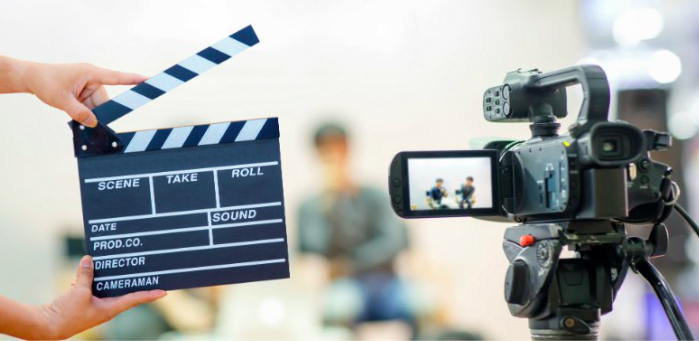

In [75]:
from IPython.display import Image
Image(filename='images/image.png') 

## Overview

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Business Problem

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

***
Questions to consider:
* What are the business's pain points related to this project?
* How did you pick the data analysis question(s) that you did?
* Why are these questions important from a business perspective?
***



They have decided to create a new movie studio. What do you suggest?

REVENUE: The amount of money a company generates from its sales. Movie domestic and interntional gross. 
Box office business can be measured in the terms of the number of tickets sold or the amount of money raised by ticket sales (revenue)

Total Gross is the earnings of all revenues no matter where they are derived so would include box office, DVD sales, PPV (pay per view) revenues and also include domestic and international sales. Included in this will also be merchandising. That becomes 'total gross'

I am planning on using Return on Investment (ROI) to determine the success of a movie. I will calculate ROI by extracting the ratio of PROFIT (worldwide gross minus budget) to the COST (budget).  

(I also want to look into the relationship between profit and rating - as one could expect them to correlate.)
    
1. WHICH GENRE(S) ARE THE MOST PROFITABLE? See how movie counts and their ratings/popularity for each genre 
changed over time. Then look into the relationship between revenue/profit and genre, which genre
creates the most revenue/profit?. (MAYBE LOOK INTO THE STUDIOS AND SEE IF 
SUCCESSFUL STUDIOS INVEST MORE ON CERTAIN GENRES? )
2. WHICH DIRECTORS CREATE THE MOST PROFITABLE MOVIES?
3. WHICH MOVIE LENGTH CREATES THE MOST PROFITABLE MOVIES?
4. DOES HIGHER RATING OR POPULARITY NECESSARILY MEAN HIGH REVENUE AND PROFIT?
5. WHICH BUDGET RANGE IS MOST PROFITABLE? DOES small budget means low revenue or no link? REVENUE and PROFIT BY BUDGET 
6. DOMESTIC VERSUS INTERNATIONAL GROSS VARY? SHOULD IT INVEST DOMESTICALLY OR INTERNATIONALLY?
    
1. Which genre(s) are most profitable? (focusing on the recent years). 

2. Which director(s) produce the most profitable films? (focusing on the recent years). 

3. Which budget range is most profitable? Does high budget movies necessarily bring more revenue? Do expensive but unsuccessful movies exist? Do inexpensive but successful movies exist? 

## Data Understanding

Describe the data being used for this project.
***
Questions to consider:
* Where did the data come from, and how do they relate to the data analysis questions?
* What do the data represent? Who is in the sample and what variables are included?
* What is the target variable?
* What are the properties of the variables you intend to use?
***

In [76]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
%matplotlib inline

**Load the IMDB database file (im.db) using SQLite and explore the tables:**

In [77]:
# Read the tables using sqlite
import sqlite3 
conn= sqlite3.connect('zippedData/im.db')

In [78]:
# Read the table movie_basics
movie_basics = pd.read_sql("""
SELECT *
FROM movie_basics;
""", conn)
movie_basics.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [79]:
movie_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [80]:
movie_basics.describe()

,start_year,runtime_minutes
count,146144.000000,114405.000000
mean,2014.621798,86.187247
std,2.733583,166.360590
min,2010.000000,1.000000
25%,2012.000000,70.000000
50%,2015.000000,87.000000
75%,2017.000000,99.000000
max,2115.000000,51420.000000


In [81]:
print(movie_basics[movie_basics['runtime_minutes'] == 51420])
print(movie_basics[movie_basics['start_year'] == 2115])
# Indeed there is a film with a runtime of 857 hours which is the longest film ever made.
# It seems like IMDB is also showing movies that are currently under development.

         movie_id primary_title original_title  start_year  runtime_minutes  \
132389  tt8273150     Logistics      Logistics        2012          51420.0   

             genres  
132389  Documentary  
        movie_id primary_title original_title  start_year  runtime_minutes  \
89506  tt5174640     100 Years      100 Years        2115              NaN   

      genres  
89506  Drama  


In [82]:
# Are there any duplicated entries?
movie_basics['movie_id'].duplicated().sum()

0

**Issues to consider about movie_basics:**
- `movie_id` is the primary key, there are 146.144 movies. 
- Use `primary_title` instead of `original_title` since it is in English.
- Since some movies have multiple `genres`, split the text and assign them to seperate rows.

In [378]:
movie_ratings = pd.read_sql("""
SELECT *
FROM movie_ratings;
""", conn)

movie_ratings.head()

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


In [379]:
movie_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


In [86]:
# suppress scientific notation output while using .describe()
movie_ratings.describe().apply(lambda x: x.apply('{0:.2f}'.format))

,averagerating,numvotes
count,73856.00,73856.00
mean,6.33,3523.66
std,1.47,30294.02
min,1.00,5.00
25%,5.50,14.00
50%,6.50,49.00
75%,7.40,282.00
max,10.00,1841066.00


In [12]:
movie_ratings['movie_id'].duplicated().sum()

0

In [87]:
movie_ratings[movie_ratings['numvotes']==1841066]

,movie_id,averagerating,numvotes
63498,tt1375666,8.8,1841066


In [88]:
# Inception indeed has been voted for 1841066 times. 
movie_basics[movie_basics['movie_id']=='tt1375666']

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
7066,tt1375666,Inception,Inception,2010,148.0,"Action,Adventure,Sci-Fi"


**Issues to consider about movie_ratings:**
- `movie_id` is the primary key, there are 73856 movies, about half the size of movies in movie_basics. 
- We can use `averagerating` as an indication of how much people like each movie but you might disregard those with low counts. 

In [89]:
directors = pd.read_sql("""
SELECT *
FROM directors;
""", conn)

directors.head()

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0462036,nm1940585
2,tt0835418,nm0151540
3,tt0835418,nm0151540
4,tt0878654,nm0089502


In [90]:
directors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291174 entries, 0 to 291173
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   movie_id   291174 non-null  object
 1   person_id  291174 non-null  object
dtypes: object(2)
memory usage: 4.4+ MB


In [91]:
directors.nunique()

movie_id     140417
person_id    109253
dtype: int64

In [93]:
print(directors.duplicated().sum())
print(directors['movie_id'].duplicated().sum())
print(directors['person_id'].duplicated().sum())
# There are 127.639 duplicated rows, 150.757 duplicated movies and 181.921 duplicated persons.

127639
150757
181921


In [94]:
directors[directors.duplicated()].sort_values(by= 'movie_id').head(10)

,movie_id,person_id
222428,tt0063540,nm0712540
222429,tt0063540,nm0712540
222430,tt0063540,nm0712540
68345,tt0069049,nm0000080
252268,tt0100275,nm0749914
252267,tt0100275,nm0765384
276830,tt0146592,nm1030585
217424,tt0162942,nm1207262
217423,tt0162942,nm1207262
19674,tt0176694,nm0417757


**Issues to consider about directors:**
- `movie_id` is the primary key, there are 291.174 movies, however about only the half (140.417) are unique entries.
- There are 127.639 duplicated rows, 150.757 duplicated movies and 181.921 duplicated persons. There is duplicated data in this table but there are also duplicated `movie id`s and `person id`s because same director probably have more than 1 movie and some movies probably have multiple directors. Need to drop the duplicated rows later. 

In [95]:
# In order to extract director name we need persons table. 
persons = pd.read_sql("""
SELECT *
FROM persons;
""", conn)

persons.head()

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator"


In [96]:
persons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606648 entries, 0 to 606647
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   person_id           606648 non-null  object 
 1   primary_name        606648 non-null  object 
 2   birth_year          82736 non-null   float64
 3   death_year          6783 non-null    float64
 4   primary_profession  555308 non-null  object 
dtypes: float64(2), object(3)
memory usage: 23.1+ MB


In [23]:
print(persons['person_id'].duplicated().sum())
print(persons['primary_name'].duplicated().sum())

0
29445


In [101]:
persons[persons['primary_name'].duplicated()].sort_values(by = 'primary_name').head(8)
# Same name has been coded under different person ID's and profession probaby due to 
# different roles they took place in different movies.

,person_id,primary_name,birth_year,death_year,primary_profession
279631,nm4062141,A. Venkatesh,NaN,NaN,"director,actor,writer"
156216,nm1701176,A. Venkatesh,NaN,NaN,"cinematographer,camera_department,editor"
387377,nm8956236,A. Venkatesh,NaN,NaN,producer
436444,nm6758318,A.J. Khan,NaN,NaN,producer
565680,nm7645047,A.K. Azad,NaN,NaN,"music_department,composer"
255710,nm3714249,AJ Perez,NaN,NaN,"producer,writer,actor"
262683,nm3942577,Aadhi,NaN,NaN,"actor,music_department,soundtrack"
446609,nm6832961,Aadhi,NaN,NaN,actor


In [102]:
persons['primary_profession'].str.contains('director').sum()

146033

**Issues to consider about persons:**
- `person_id` is the primary key, there are 606.648 people entries, however only about 146.033 of them are "directors". 
- We only need `primary_name` information as well as `person_id` to link this table to directors table.
- Same name has been coded under different person ID's and profession probably due to different roles in different movies. Therefore there are duplicated entries. 

**EXTRACT A COMPREHENSIVE IMDB DATA FRAME FROM THE DATABASE USING FOUR TABLES:**
- movie_basics - to get title, year, runtime, and genre information for each movie. 
- movie_ratings - to get average rating and number of votes
- directors - to get the director ID information for each movie 
- persons - to be able to link the directors to their names

In [103]:
length_movie_id = [len(x['movie_id']) for x in [movie_basics, movie_ratings, directors]]
length_movie_id

[146144, 73856, 291174]

In [458]:
# Left join movie_ratings because we want to keep all records regardless they have a rating. 
# Left join directors because we want to keep all records regardless they have a director. 
# Inner join persons because we do NOT want the people who are NOT directors in the dataset. 

imdb = pd.read_sql("""
SELECT DISTINCT movie_id, 
       primary_title,
       start_year,
       runtime_minutes,
       genres,
       averagerating,
       numvotes,
       person_id,
       primary_name as director_name
FROM movie_basics
LEFT JOIN movie_ratings
    USING(movie_id)
LEFT JOIN directors  
    USING(movie_id)
JOIN persons
    USING(person_id)
ORDER BY (movie_id)

""", conn)

print(imdb.shape)

imdb.head()

(163533, 9)


,movie_id,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes,person_id,director_name
0,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77.0,nm0712540,Harnam Singh Rawail
1,tt0066787,One Day Before the Rainy Season,2019,114.0,"Biography,Drama",7.2,43.0,nm0002411,Mani Kaul
2,tt0069049,The Other Side of the Wind,2018,122.0,Drama,6.9,4517.0,nm0000080,Orson Welles
3,tt0069204,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13.0,nm0611531,Hrishikesh Mukherjee
4,tt0100275,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy",6.5,119.0,nm0749914,Raoul Ruiz


In [459]:
imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163533 entries, 0 to 163532
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         163533 non-null  object 
 1   primary_title    163533 non-null  object 
 2   start_year       163533 non-null  int64  
 3   runtime_minutes  130938 non-null  float64
 4   genres           159789 non-null  object 
 5   averagerating    86030 non-null   float64
 6   numvotes         86030 non-null   float64
 7   person_id        163533 non-null  object 
 8   director_name    163533 non-null  object 
dtypes: float64(3), int64(1), object(5)
memory usage: 11.2+ MB


In [460]:
imdb['movie_id'].nunique()
# There are 140,416 unique movie ID's 

140416

In [461]:
imdb[imdb['primary_title'].duplicated()]

,movie_id,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes,person_id,director_name
5,tt0100275,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy",6.5,119.0,nm0765384,Valeria Sarmiento
10,tt0139613,O Silêncio,2012,NaN,"Documentary,History",NaN,NaN,nm0518037,António Loja Neves
24,tt0253093,Gangavataran,2018,134.0,None,6.6,8.0,nm0679610,Dhundiraj Govind Phalke
32,tt0283440,Short Time Heroes,2015,45.0,Sci-Fi,6.6,16.0,nm1549344,Roman Gonther
40,tt0312305,Quantum Quest: A Cassini Space Odyssey,2010,45.0,"Adventure,Animation,Sci-Fi",5.1,287.0,nm1004541,Harry 'Doc' Kloor
...,...,...,...,...,...,...,...,...,...
163512,tt9914642,Albatross,2017,NaN,Documentary,8.5,8.0,nm5300859,Chris Jordan
163521,tt9916160,Drømmeland,2019,72.0,Documentary,6.5,11.0,nm5684093,Joost van der Wiel
163522,tt9916170,The Rehearsal,2019,51.0,Drama,NaN,NaN,nm5412267,Tamar Guimaraes
163528,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary,NaN,NaN,nm9272491,Ana Célia de Oliveira


In [462]:
imdb[imdb['primary_title'] == 'Albatross']

,movie_id,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes,person_id,director_name
9381,tt1541149,Albatross,2011,90.0,Drama,6.4,4872.0,nm1732975,Niall MacCormick
60162,tt3128706,Albatross,2015,89.0,"Comedy,Drama,Sport",6.9,90.0,nm5885379,Snævar Sölvason
163512,tt9914642,Albatross,2017,NaN,Documentary,8.5,8.0,nm5300859,Chris Jordan


**Read csv file "bom.movie_gross.csv.gz":**

In [463]:
budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz', )
budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [464]:
budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [465]:
budgets['movie'].nunique()

5698

In [466]:
budgets['movie'].duplicated().sum()

84

In [467]:
budgets[budgets['movie'].duplicated()]

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
273,74,"May 19, 1998",Godzilla,"$125,000,000","$136,314,294","$376,000,000"
408,9,"Nov 21, 2018",Robin Hood,"$99,000,000","$30,824,628","$84,747,441"
484,85,"Jul 8, 2005",Fantastic Four,"$87,500,000","$154,696,080","$333,132,750"
543,44,"May 7, 1999",The Mummy,"$80,000,000","$155,385,488","$416,385,488"
707,8,"Jun 13, 1997",Hercules,"$70,000,000","$99,112,101","$250,700,000"
...,...,...,...,...,...,...
5668,69,"Nov 16, 1942",Cat People,"$134,000","$4,000,000","$8,000,000"
5676,77,"Oct 1, 1968",Night of the Living Dead,"$114,000","$12,087,064","$30,087,064"
5677,78,"Feb 8, 1915",The Birth of a Nation,"$110,000","$10,000,000","$11,000,000"
5699,100,"Aug 30, 1972",The Last House on the Left,"$87,000","$3,100,000","$3,100,000"


In [468]:
budgets[budgets['movie'] == 'Godzilla']

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
140,41,"May 16, 2014",Godzilla,"$160,000,000","$200,676,069","$529,076,069"
273,74,"May 19, 1998",Godzilla,"$125,000,000","$136,314,294","$376,000,000"


**Issues to consider about budgets:**
- `movie` is the key to merge with imdb dataset. 
- `production_budget`, `domestic_gross`, `worldwide_gross` all coded as a string. Remove the $ sign and covert to integer. 
- `release_date` coded as a string, convert it to time datatype. 
- There are also 84 movies sharing a name. So we need to take "year" into consideratoion as well while merging. 

In [469]:
# Remove the $ sign and the comma, and convert string into integer. 
# Write a function to do this for multiple columns. 
def strreplace(df_original,vrbl_list):
    df_modified = df_original.copy()
    for x in vrbl_list:
        df_modified[x] = df_modified[x].str.replace('$','').str.replace(',','').astype(int)
    return(df_modified)

In [470]:
budgets_clean = strreplace(budgets, [('production_budget'), ('worldwide_gross'),('domestic_gross')])
budgets_clean.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747


In [471]:
# Column id is redundant with index
budgets_clean.drop('id', inplace=True, axis=1)

In [472]:
# Convert release_date into datetime
budgets_clean['release_date'] = pd.to_datetime(budgets_clean['release_date']) 

In [473]:
budgets_clean['release_year'] = budgets_clean['release_date'].dt.year

In [474]:
budgets_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   release_date       5782 non-null   datetime64[ns]
 1   movie              5782 non-null   object        
 2   production_budget  5782 non-null   int64         
 3   domestic_gross     5782 non-null   int64         
 4   worldwide_gross    5782 non-null   int64         
 5   release_year       5782 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 271.2+ KB


**Merge budgets with IMDB to get a master dataset using movie name:**
- ISSUE: Some movie titles do not match between imdb and budgets datasets. Try to clean/match the movie names first.

In [492]:
# Replace punctiations with empty strings so the discreapncies based on punctuation between the movie titles will disappear. 

budgets_clean = budgets_clean.copy()
imdb = imdb.copy()

budgets_clean['movie'] = budgets_clean['movie'].str.replace(':','').str.replace(',','').str.replace('-','').str.replace(';','').str.replace('[^\w\s]','').str.replace('Ep.','Episode', regex=False)
imdb['primary_title'] = imdb['primary_title'].str.replace(':','').str.replace(',','').str.replace('-','').str.replace(';','').str.replace('[^\w\s]','').str.replace('Ep.','Episode', regex=False)

In [493]:
master = imdb.merge(budgets_clean, left_on='primary_title', right_on='movie', how='inner')
master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4263 entries, 0 to 4262
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   movie_id           4263 non-null   object        
 1   primary_title      4263 non-null   object        
 2   start_year         4263 non-null   int64         
 3   runtime_minutes    3755 non-null   float64       
 4   genres             4218 non-null   object        
 5   averagerating      3254 non-null   float64       
 6   numvotes           3254 non-null   float64       
 7   person_id          4263 non-null   object        
 8   director_name      4263 non-null   object        
 9   release_date       4263 non-null   datetime64[ns]
 10  movie              4263 non-null   object        
 11  production_budget  4263 non-null   int64         
 12  domestic_gross     4263 non-null   int64         
 13  worldwide_gross    4263 non-null   int64         
 14  release_

**Clean master dataset:**

In [497]:
master_clean = master.copy()

In [498]:
master_clean.drop(['movie', 'person_id', 'start_year'], axis=1, inplace=True)

In [499]:
master_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4263 entries, 0 to 4262
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   movie_id           4263 non-null   object        
 1   primary_title      4263 non-null   object        
 2   runtime_minutes    3755 non-null   float64       
 3   genres             4218 non-null   object        
 4   averagerating      3254 non-null   float64       
 5   numvotes           3254 non-null   float64       
 6   director_name      4263 non-null   object        
 7   release_date       4263 non-null   datetime64[ns]
 8   production_budget  4263 non-null   int64         
 9   domestic_gross     4263 non-null   int64         
 10  worldwide_gross    4263 non-null   int64         
 11  release_year       4263 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(4), object(4)
memory usage: 433.0+ KB


- Some movies have missing data on `averagerating`, `runtime_minutes` and `genres`, but we will keep all this data in thge master sheet.

### CREATE THE DEPENDENT VARIABLES AND SLICE THE DATA TO ASSESS "PROFITABILITY":

**Create new columns:**
- `profit` to represent profit and 
- `roi'` to represent "return on investment"
- `success_bins` - SLICE the data into 4 success categories based on median profit and ROI values to get more specific answers. 
- `budget_bins`- SLICE the data into 4 budget ranges based on quartiles to get more specific answers. 

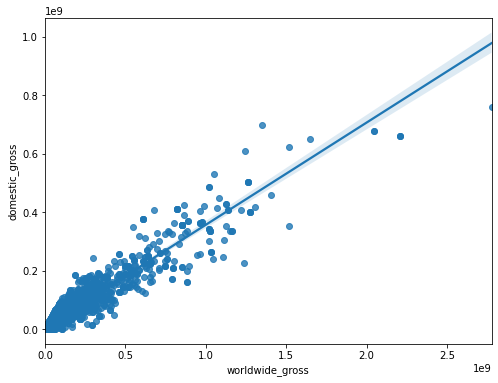

In [556]:
fig, ax1 = plt.subplots(figsize=(8, 6))
sns.regplot(data = master_clean, x ='worldwide_gross', y='domestic_gross', ax=ax1);
# There is a strong correlation between domestic and worldwide gross
# Let's use "worldwide gross" for calculating profit and roi to get a more comprehensive estimate. 

In [500]:
# Create profit and ROI columns:
master_clean['profit'] = master_clean['worldwide_gross'] - master_clean['production_budget'] 
master_clean['roi'] = ( (master_clean['worldwide_gross'] - master_clean['production_budget']) / master_clean['production_budget'] ) *100


In [501]:
print(master_clean['profit'].median())
print(master_clean['roi'].median())
print(master_clean['production_budget'].quantile(q=(.25,.5, .75)))

7787943.0
50.37867
0.25     4500000.0
0.50    15000000.0
0.75    40000000.0
Name: production_budget, dtype: float64


**Create Success Categories using the Median values for ROI and PROFIT as cutoff**:
- high profit high ROI
- high profit low ROI
- low profit high ROI
- low profit low ROI

In [503]:
master_clean['roi_bins'] = master_clean['roi'].map(lambda x: '< 50%' if x<=master_clean['roi'].median() else ('> 50%'))
master_clean['profit_bins'] = master_clean['profit'].map(lambda x: '< 7.8 M' if x<=master_clean['profit'].median() else ('> 7.8 M'))
master_clean['roi_profit_bins'] = master_clean['roi_bins'] + ' ' + master_clean['profit_bins']


In [632]:
master_clean['budget_bins'] = pd.qcut(master_clean['production_budget'], q=4, labels=['<4.5 M', '4.5-15 M', '15-40 M', '>40 M'])


In [633]:
master_clean.sample(5)

,movie_id,primary_title,runtime_minutes,genres,averagerating,numvotes,director_name,release_date,production_budget,domestic_gross,worldwide_gross,release_year,profit,roi,roi_bins,profit_bins,roi_profit_bins,budget_bins
20,tt0398286,Tangled,100.0,"Adventure,Animation,Comedy",7.8,366366.0,Nathan Greno,2010-11-24,260000000,200821936,586477240,2010,326477240,125.568169,> 50%,> 7.8 M,> 50% > 7.8 M,>40 M
759,tt1244754,Conviction,107.0,"Biography,Crime,Drama",7.2,39771.0,Tony Goldwyn,2010-10-15,12500000,6797696,11826980,2010,-673020,-5.384160,< 50%,< 7.8 M,< 50% < 7.8 M,4.5-15 M
3858,tt4653310,Driving Miss Daisy,100.0,"Comedy,Drama",8.2,122.0,David Esbjornson,1989-12-13,7500000,106593296,106593296,1989,99093296,1321.243947,> 50%,> 7.8 M,> 50% > 7.8 M,4.5-15 M
1879,tt8755316,The Island,134.0,"Comedy,Drama",6.2,1001.0,Bo Huang,1980-06-13,22000000,15716828,15716828,1980,-6283172,-28.559873,< 50%,< 7.8 M,< 50% < 7.8 M,15-40 M
3246,tt7599406,Waiting,178.0,None,9.1,82.0,Feng Lin,2005-10-07,1125000,16124543,18673274,2005,17548274,1559.846578,> 50%,> 7.8 M,> 50% > 7.8 M,<4.5 M


In [634]:
# # MASTER dataset included duplicated entries due to multiple directors. Drop these first.
master_clean_distinctmovies = master_clean.copy()

In [635]:
master_clean_distinctmovies['movie_id'].duplicated().sum()

669

In [636]:
master_clean_distinctmovies = master_clean_distinctmovies.drop_duplicates(subset='movie_id').reset_index(drop=True)

In [637]:
assert(master_clean_distinctmovies['movie_id'].duplicated().sum() ==0)

In [638]:
len(master_clean_distinctmovies['movie_id'])

3594

In [639]:
success_pivot = master_clean_distinctmovies.pivot_table(index=['roi_bins','profit_bins'],
                                         values='roi',
                                         columns=['budget_bins'],
                                         aggfunc=['mean','count'], fill_value=0 )

success_pivot = success_pivot.style.format("{:.2f}").background_gradient(cmap='Purples', low=0, high=0.75)
success_pivot
#https://towardsdatascience.com/adding-style-to-pandas-in-just-a-few-lines-of-code-be942f65b3a5

**Table shows that:**
- Low Roi - Low Profit movies had more lower budget movies but more ROI gains with higher budgets.
- Low Roi - High Profit movies had bigger budget movies only - so bigger room for more profit.
- High Roi - Low Profit movies had lower budget movies only - so bigger room for more return on investment. 
- High Roi - High Profit movies had more higher budget movies but more ROI gains with smaller budgets.

### QUESTION1: WHICH MOVIE GENRE IS MORE PROFITABLE?

In [640]:
df_genre = master_clean_distinctmovies.copy()

In [641]:
df_genre = df_genre.drop(['runtime_minutes', 'numvotes', 'director_name', 'release_date'], axis=1)

In [642]:
df_genre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3594 entries, 0 to 3593
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   movie_id           3594 non-null   object  
 1   primary_title      3594 non-null   object  
 2   genres             3560 non-null   object  
 3   averagerating      2794 non-null   float64 
 4   production_budget  3594 non-null   int64   
 5   domestic_gross     3594 non-null   int64   
 6   worldwide_gross    3594 non-null   int64   
 7   release_year       3594 non-null   int64   
 8   profit             3594 non-null   int64   
 9   roi                3594 non-null   float64 
 10  roi_bins           3594 non-null   object  
 11  profit_bins        3594 non-null   object  
 12  roi_profit_bins    3594 non-null   object  
 13  budget_bins        3594 non-null   category
dtypes: category(1), float64(2), int64(5), object(6)
memory usage: 368.8+ KB


In [643]:
# Dropping the 34 rows where Genre is null. 
df_genre = df_genre.dropna(subset=['genres']).reset_index(drop=True)

In [644]:
# Split the genres seperated by commas and expand them into different rows
# df_genre.explode('genres') This function expands to different rows.

df_genre['genres'] = df_genre['genres'].str.split(',')
df_genre = df_genre.explode('genres') # .explode() adds more rows
df_genre.head()

,movie_id,primary_title,genres,averagerating,production_budget,domestic_gross,worldwide_gross,release_year,profit,roi,roi_bins,profit_bins,roi_profit_bins,budget_bins
0,tt0249516,Foodfight,Action,1.9,45000000,0,73706,2012,-44926294,-99.836209,< 50%,< 7.8 M,< 50% < 7.8 M,>40 M
0,tt0249516,Foodfight,Animation,1.9,45000000,0,73706,2012,-44926294,-99.836209,< 50%,< 7.8 M,< 50% < 7.8 M,>40 M
0,tt0249516,Foodfight,Comedy,1.9,45000000,0,73706,2012,-44926294,-99.836209,< 50%,< 7.8 M,< 50% < 7.8 M,>40 M
1,tt0293429,Mortal Kombat,Action,NaN,20000000,70433227,122133227,1995,102133227,510.666135,> 50%,> 7.8 M,> 50% > 7.8 M,15-40 M
1,tt0293429,Mortal Kombat,Adventure,NaN,20000000,70433227,122133227,1995,102133227,510.666135,> 50%,> 7.8 M,> 50% > 7.8 M,15-40 M


In [645]:
df_genre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7475 entries, 0 to 3559
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   movie_id           7475 non-null   object  
 1   primary_title      7475 non-null   object  
 2   genres             7475 non-null   object  
 3   averagerating      6282 non-null   float64 
 4   production_budget  7475 non-null   int64   
 5   domestic_gross     7475 non-null   int64   
 6   worldwide_gross    7475 non-null   int64   
 7   release_year       7475 non-null   int64   
 8   profit             7475 non-null   int64   
 9   roi                7475 non-null   float64 
 10  roi_bins           7475 non-null   object  
 11  profit_bins        7475 non-null   object  
 12  roi_profit_bins    7475 non-null   object  
 13  budget_bins        7475 non-null   category
dtypes: category(1), float64(2), int64(5), object(6)
memory usage: 825.1+ KB


In [646]:
df_genre.groupby("genres")['movie_id'].count().sort_values()

genres
Reality-TV        1
News              7
Western          24
Musical          31
War              48
Sport            71
Music            85
History          89
Animation       144
Fantasy         184
Family          187
Sci-Fi          222
Biography       237
Mystery         240
Romance         367
Crime           394
Horror          404
Documentary     447
Adventure       471
Thriller        577
Action          668
Comedy          840
Drama          1737
Name: movie_id, dtype: int64

In [647]:
# select those genres which produced at least 50 movies to be able to draw reliable conclusions:
df_genre = df_genre.groupby("genres").filter(lambda x: len(x) > 50) 
df_genre.groupby("genres")['movie_id'].count()

genres
Action          668
Adventure       471
Animation       144
Biography       237
Comedy          840
Crime           394
Documentary     447
Drama          1737
Family          187
Fantasy         184
History          89
Horror          404
Music            85
Mystery         240
Romance         367
Sci-Fi          222
Sport            71
Thriller        577
Name: movie_id, dtype: int64

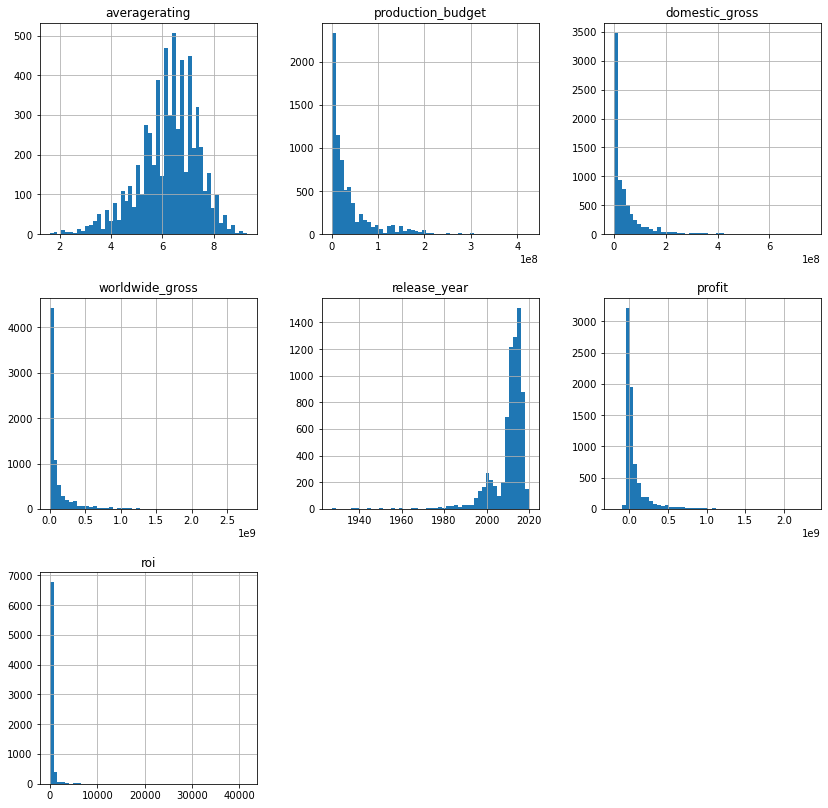

In [648]:
df_genre.hist(bins=50, figsize=(14,14));
# All of the variables are highly skewed except average rating. 

In [650]:
df_genre_budget1 = df_genre[df_genre['budget_bins'] == '<40 M']
df_genre_budget2 = df_genre[df_genre['budget_bins'] == '15-40 M']
df_genre_budget3 = df_genre[df_genre['budget_bins'] == '4.5-15 M']
df_genre_budget4 = df_genre[df_genre['budget_bins'] == '>4.5 M']

Based on 4 different budget ranges create different histograms to see if data is still highly skewed:

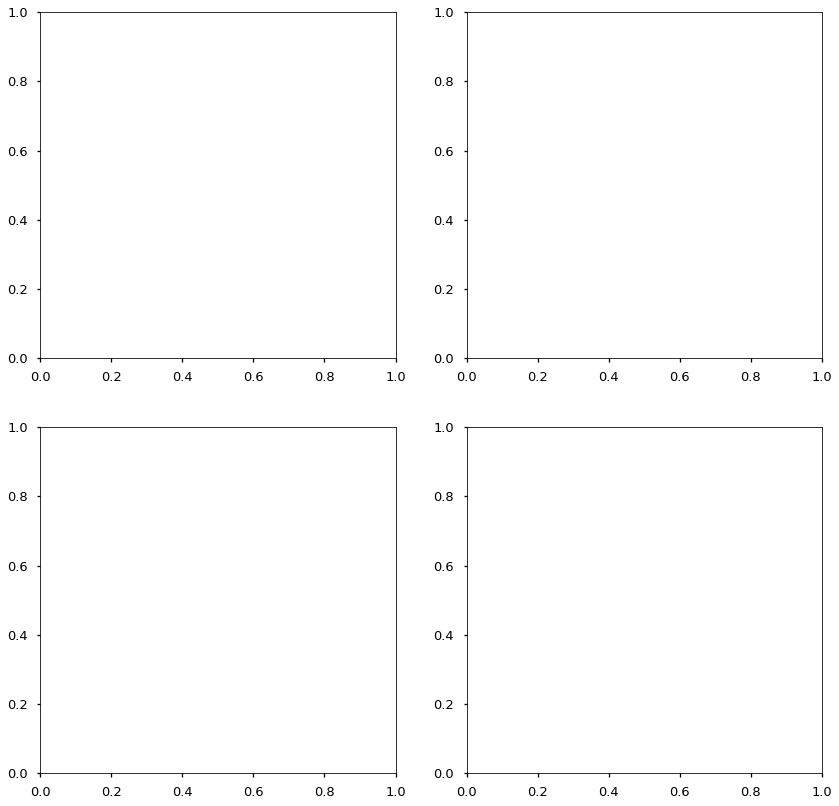

In [651]:
with plt.style.context('seaborn-talk'):
    fig, ( (ax1, ax2),(ax3, ax4) )  = plt.subplots(ncols=2, nrows= 2, figsize=(14, 14))
    sns.histplot(x = df_genre_budget1['roi'], ax=ax1)
    sns.histplot(x = df_genre_budget1['roi'], ax=ax2)
    sns.histplot(x = df_genre_budget1['roi'], ax=ax3)
    sns.histplot(x = df_genre_budget1['roi'], ax=ax4)

In [652]:
df_genre_table = df_genre.groupby('genres')[['profit', 'roi']].agg(['mean', 'median','count'])
df_genre_table.reset_index(inplace=True)
df_genre_table

genres        profit                            roi                  
                         mean       median count        mean      median count
0        Action  1.201770e+08   31065333.5   668  230.598774   76.506716   668
1     Adventure  2.005464e+08   71306500.0   471  184.115410  128.639688   471
2     Animation  2.230584e+08  129674435.0   144  323.994050  176.281140   144
3     Biography  4.331830e+07    5182050.0   237  310.901354   43.896543   237
4        Comedy  6.961417e+07   15173438.0   840  254.816509   86.325243   840
5         Crime  3.817521e+07    2881448.0   394  125.306964   27.067462   394
6   Documentary  4.038347e+07    1684207.0   447  229.131478   30.732634   447
7         Drama  3.631899e+07    2746453.0  1737  215.832743   33.444444  1737
8        Family  1.028811e+08   18752858.0   187  253.963727   85.408911   187
9       Fantasy  1.427138e+08   28914614.0   184  290.387892   95.493715   184
10      History  4.271275e+07    5348205.0    89  101.784345   38.021009    89
11       Horror  4.501765e+07    4717180.0   404  537.587360   46.050406   404
12        Music  4.680629e+07    3657914.0    85  220.893711   63.206830    85
13      Mystery  4.754767e+07   14038616.5   240  592.986082   92.143694   240
14      Romance  3.769841e+07    5882226.0   367  286.302235   65.420546   367
15       Sci-Fi  1.641707e+08   23230535.0   222  200.825514  119.611842   222
16        Sport  4.558300e+07     -37395.0    71  304.129496   -3.138460    71
17     Thriller  5.032815e+07    3475778.0   577  350.315325   39.330956   577

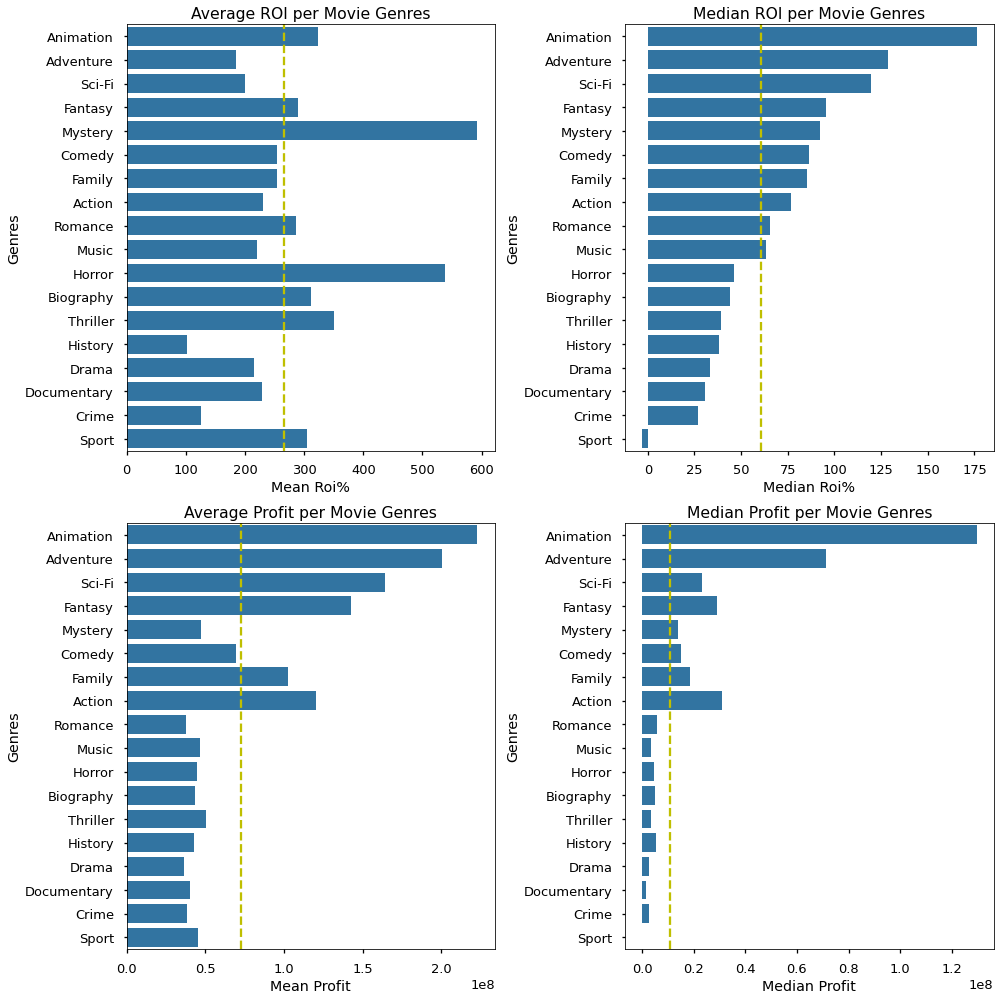

In [667]:
# Add a line to show the overall_median_roi for all movies.

df_genre_table = df_genre_table.sort_values([('roi','median')], ascending = False)
with plt.style.context('seaborn-talk'):
    base_color = sns.color_palette()[0]
    fig, ( (ax1, ax2), (ax3, ax4) ) = plt.subplots(ncols=2, nrows=2, figsize=(14, 14))

    sns.barplot(x = df_genre_table['roi','mean'], y= df_genre_table['genres'], ax=ax1, color = base_color) 
    ax1.axvline(x= df_genre['roi'].mean(), ymin=0, ymax=1, color='y', linestyle='--')
    sns.barplot(x = df_genre_table['roi','median'], y= df_genre_table['genres'], ax=ax2, color = base_color)
    ax2.axvline(x= df_genre['roi'].median(), ymin=0, ymax=1, color='y', linestyle='--')
    sns.barplot(x = df_genre_table['profit','mean'], y= df_genre_table['genres'],  ax=ax3, color = base_color)
    ax3.axvline(x= df_genre['profit'].mean(), ymin=0, ymax=1, color='y', linestyle='--')
    sns.barplot(x = df_genre_table['profit','median'], y= df_genre_table['genres'],  ax=ax4, color = base_color)
    ax4.axvline(x= df_genre['profit'].median(), ymin=0, ymax=1, color='y', linestyle='--')
    
    ax1.set_title('Average ROI per Movie Genres')
    ax2.set_title('Median ROI per Movie Genres')
    ax3.set_title('Average Profit per Movie Genres')
    ax4.set_title('Median Profit per Movie Genres')
    
    ax1.set_xlabel("Mean Roi%")
    ax2.set_xlabel("Median Roi%")
    ax3.set_xlabel("Mean Profit")
    ax4.set_xlabel("Median Profit")
    ax1.set_ylabel("Genres")
    ax2.set_ylabel("Genres")
    ax3.set_ylabel("Genres")
    ax4.set_ylabel("Genres")
    
    fig.tight_layout();

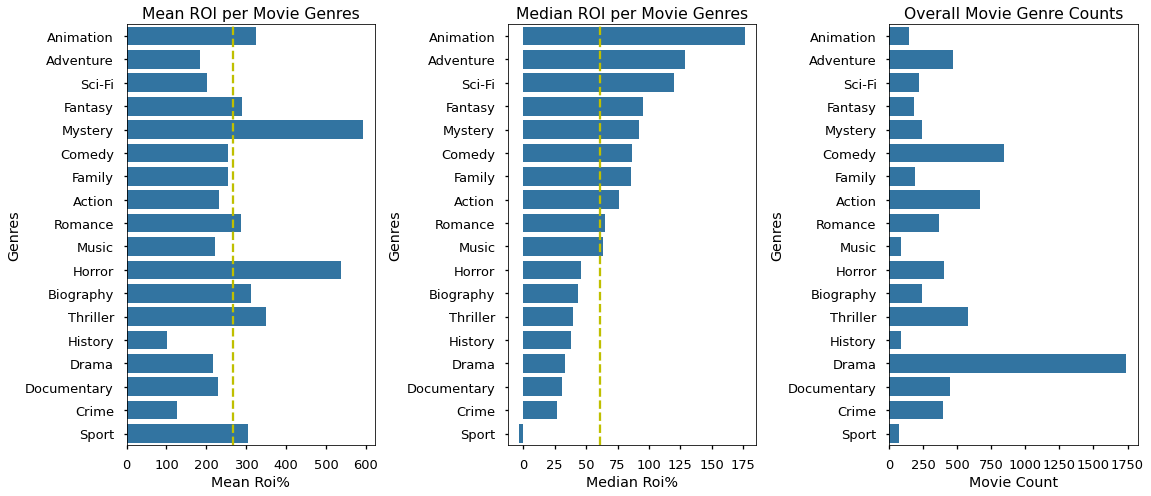

In [666]:
# Add a line to show the overall_median_roi for all movies.

df_genre_table = df_genre_table.sort_values([('roi','median')], ascending = False)
with plt.style.context('seaborn-talk'):
    base_color = sns.color_palette()[0]
    fig, ( ax1, ax2, ax3 ) = plt.subplots(ncols=3, figsize=(16, 7))

    sns.barplot(x = df_genre_table['roi','mean'], y= df_genre_table['genres'], ax=ax1, color = base_color) 
    ax1.axvline(x= df_genre['roi'].mean(), ymin=0, ymax=1, color='y', linestyle='--')
    sns.barplot(x = df_genre_table['roi','median'], y= df_genre_table['genres'], ax=ax2, color = base_color)
    ax2.axvline(x= df_genre['roi'].median(), ymin=0, ymax=1, color='y', linestyle='--')
    sns.barplot(x = df_genre_table['roi','count'], y= df_genre_table['genres'],  ax=ax3, color = base_color)

    ax1.set_title('Mean ROI per Movie Genres')
    ax2.set_title('Median ROI per Movie Genres')
    ax3.set_title('Overall Movie Genre Counts')
    
    ax1.set_xlabel("Mean Roi%")
    ax2.set_xlabel("Median Roi%")
    ax3.set_xlabel("Movie Count")

    ax1.set_ylabel("Genres")
    ax2.set_ylabel("Genres")
    ax3.set_ylabel("Genres")
    
    fig.tight_layout();

In [669]:
[df_genre['budget_bins'].unique()]

[['>40 M', '15-40 M', '<4.5 M', '4.5-15 M']
 Categories (4, object): ['<4.5 M' < '4.5-15 M' < '15-40 M' < '>40 M']]

In [684]:
for i in ['>40 M', '15-40 M', '<4.5 M', '4.5-15 M']:
    print('budget_bins' + i)

budget_bins>40 M
budget_bins15-40 M
budget_bins<4.5 M
budget_bins4.5-15 M


In [727]:
df = df_genre.copy()


# for df in [df1, df2, df3, df4]:

for j in ['>40 M', '15-40 M', '<4.5 M', '4.5-15 M']:
    for i in range(0,4):
        dfi = df[df['budget_bins'] == j]
       # df_new = df_new.groupby("genres").filter(lambda x: len(x) >= 10) 
        #df_new = pd.DataFrame(df_new.groupby('genres')['roi'].median())
       #df_new = df_new.reset_index()
dfi          

,movie_id,primary_title,genres,averagerating,production_budget,domestic_gross,worldwide_gross,release_year,profit,roi,roi_bins,profit_bins,roi_profit_bins,budget_bins
19,tt0403935,Action Jackson,Action,3.3,7000000,20257000,20257000,1988,13257000,189.385714,> 50%,> 7.8 M,> 50% > 7.8 M,4.5-15 M
19,tt0403935,Action Jackson,Thriller,3.3,7000000,20257000,20257000,1988,13257000,189.385714,> 50%,> 7.8 M,> 50% > 7.8 M,4.5-15 M
22,tt0431021,The Possession,Horror,5.9,14000000,49130588,82925064,2012,68925064,492.321886,> 50%,> 7.8 M,> 50% > 7.8 M,4.5-15 M
22,tt0431021,The Possession,Mystery,5.9,14000000,49130588,82925064,2012,68925064,492.321886,> 50%,> 7.8 M,> 50% > 7.8 M,4.5-15 M
22,tt0431021,The Possession,Thriller,5.9,14000000,49130588,82925064,2012,68925064,492.321886,> 50%,> 7.8 M,> 50% > 7.8 M,4.5-15 M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3542,tt9087212,Little Voice,Thriller,NaN,6000000,4595000,21787233,1998,15787233,263.120550,> 50%,> 7.8 M,> 50% > 7.8 M,4.5-15 M
3555,tt9729206,Diner,Crime,NaN,5000000,12592907,12592907,1982,7592907,151.858140,> 50%,< 7.8 M,> 50% < 7.8 M,4.5-15 M
3558,tt9889814,Kiss Kiss Bang Bang,Crime,NaN,15000000,4235837,16829464,2005,1829464,12.196427,< 50%,< 7.8 M,< 50% < 7.8 M,4.5-15 M
3558,tt9889814,Kiss Kiss Bang Bang,Romance,NaN,15000000,4235837,16829464,2005,1829464,12.196427,< 50%,< 7.8 M,< 50% < 7.8 M,4.5-15 M


In [736]:
df1 = df_genre[df_genre['budget_bins'] == '<4.5 M']
df1_table = df1.groupby("genres").filter(lambda x: len(x) >= 20) 
df1_table = pd.DataFrame(df1_table.groupby('genres')['roi'].median()).reset_index()

df2 = df_genre[df_genre['budget_bins'] == '15-40 M']
df2_table = df2.groupby("genres").filter(lambda x: len(x) >= 20) 
df2_table = pd.DataFrame(df2_table.groupby('genres')['roi'].median()).reset_index()

df3 = df_genre[df_genre['budget_bins'] == '4.5-15 M']
df3_table = df3.groupby("genres").filter(lambda x: len(x) >= 20) 
df3_table = pd.DataFrame(df3_table.groupby('genres')['roi'].median()).reset_index()

df4 = df_genre[df_genre['budget_bins'] == '>40 M']
df4_table = df4.groupby("genres").filter(lambda x: len(x) >= 20) 
df4_table = pd.DataFrame(df4_table.groupby('genres')['roi'].median()).reset_index()


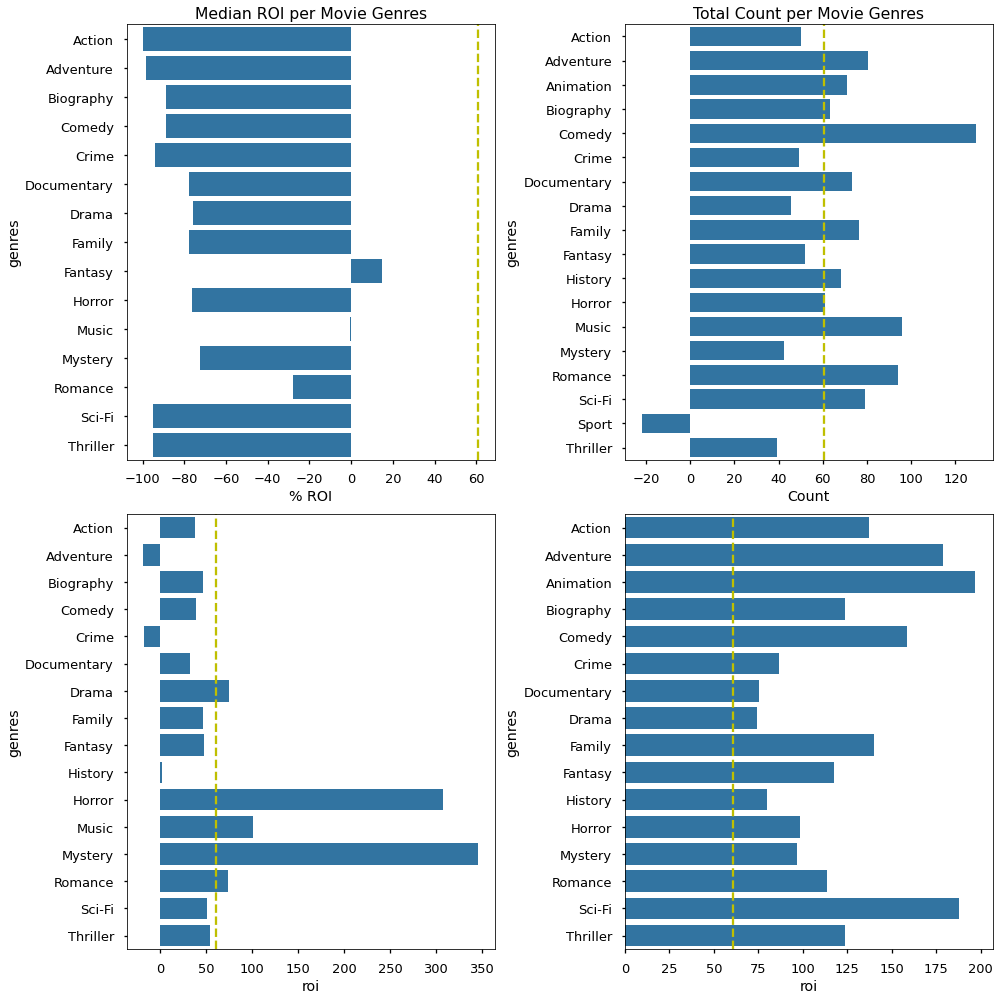

In [741]:
# When sorting by a MultiIndex you need to contain the tuple describing the column inside a list
# df_genre_table = df_genre_table.sort_values([('roi','median')], ascending = False)
with plt.style.context('seaborn-talk'):
    fig, ( (ax1, ax2),(ax3, ax4) )  = plt.subplots(ncols=2, nrows= 2, figsize=(14, 14))
    
    sns.barplot(data = df1_table, x = 'roi', y= 'genres', ax=ax1, color = base_color) 
    ax1.axvline(x= df_genre['roi'].median(), ymin=0, ymax=1, color='y', linestyle='--')
    sns.barplot(data = df2_table, x = 'roi', y= 'genres', ax=ax2, color = base_color) 
    ax2.axvline(x= df_genre['roi'].median(), ymin=0,ymax=1, color='y', linestyle='--')
    sns.barplot(data = df3_table, x = 'roi', y= 'genres', ax=ax3, color = base_color) 
    ax3.axvline(x= df_genre['roi'].median(), ymin=0, ymax=1, color='y', linestyle='--')
    sns.barplot(data = df4_table, x = 'roi', y= 'genres', ax=ax4, color = base_color) 
    ax4.axvline(x= df_genre['roi'].median(), ymin=0, ymax=1, color='y', linestyle='--')

    ax1.set_title('Median ROI per Movie Genres')
    ax2.set_title("Total Count per Movie Genres")
    ax1.set_xlabel("% ROI")
    ax2.set_xlabel("Count")
    fig.tight_layout();

In [574]:
# IF YOU CAN GO HIGHER IN BUDGET YOU CAN PROBABLY GET BOTH HIGHER PROFIT AND ROI WITH HORROR AND MYSTERY. 
# When sorting by a MultiIndex you need to contain the tuple describing the column inside a list


In [742]:
proportion = ((df_genre[df_genre['roi_profit_bins']=='> 50% > 7.8 M'].groupby('genres')['movie_id'].count())*100) /(df_genre.groupby('genres')['movie_id'].count())

df_proportion = pd.DataFrame(data = proportion)      #  columns = ['proportion'] not working
df_proportion

,movie_id
genres,
Action,54.790419
Adventure,64.755839
Animation,71.527778
Biography,46.413502
Comedy,52.857143
Crime,40.355330
Documentary,39.149888
Drama,41.681059
Family,53.475936


In [749]:
df_proportion.reset_index(inplace=True)

In [750]:
df_proportion['movie_id']

0     54.790419
1     64.755839
2     71.527778
3     46.413502
4     52.857143
5     40.355330
6     39.149888
7     41.681059
8     53.475936
9     54.347826
10    43.820225
11    44.554455
12    44.705882
13    48.333333
14    45.504087
15    54.954955
16    36.619718
17    44.020797
Name: movie_id, dtype: float64

In [746]:
df_genre_table.reset_index(inplace=True, drop=True)

In [751]:
df_genre_table['proportion'] = df_proportion['movie_id'] # You need to make sure index are the same between the two df. 
df_genre_table

index       genres        profit                            roi  \
                               mean       median count        mean   
0      2    Animation  2.230584e+08  129674435.0   144  323.994050   
1      1    Adventure  2.005464e+08   71306500.0   471  184.115410   
2     15       Sci-Fi  1.641707e+08   23230535.0   222  200.825514   
3      9      Fantasy  1.427138e+08   28914614.0   184  290.387892   
4     13      Mystery  4.754767e+07   14038616.5   240  592.986082   
5      4       Comedy  6.961417e+07   15173438.0   840  254.816509   
6      8       Family  1.028811e+08   18752858.0   187  253.963727   
7      0       Action  1.201770e+08   31065333.5   668  230.598774   
8     14      Romance  3.769841e+07    5882226.0   367  286.302235   
9     12        Music  4.680629e+07    3657914.0    85  220.893711   
10    11       Horror  4.501765e+07    4717180.0   404  537.587360   
11     3    Biography  4.331830e+07    5182050.0   237  310.901354   
12    17     Thriller  5.032815e+07    3475778.0   577  350.315325   
13    10      History  4.271275e+07    5348205.0    89  101.784345   
14     7        Drama  3.631899e+07    2746453.0  1737  215.832743   
15     6  Documentary  4.038347e+07    1684207.0   447  229.131478   
16     5        Crime  3.817521e+07    2881448.0   394  125.306964   
17    16        Sport  4.558300e+07     -37395.0    71  304.129496   

                     proportion  
        median count             
0   176.281140   144  54.790419  
1   128.639688   471  64.755839  
2   119.611842   222  71.527778  
3    95.493715   184  46.413502  
4    92.143694   240  52.857143  
5    86.325243   840  40.355330  
6    85.408911   187  39.149888  
7    76.506716   668  41.681059  
8    65.420546   367  53.475936  
9    63.206830    85  54.347826  
10   46.050406   404  43.820225  
11   43.896543   237  44.554455  
12   39.330956   577  44.705882  
13   38.021009    89  48.333333  
14   33.444444  1737  45.504087  
15   30.732634   447  54.954955  
16   27.067462   394  36.619718  
17   -3.138460    71  44.020797

In [ ]:
# df_genre_table = df_genre_table.merge(df_proportion, on='genres')
# df_genre_table.columns

In [ ]:
df_genre_table = df_genre_table.sort_values([('roi','median')], ascending = False)
with plt.style.context('seaborn-talk'):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 7))

    sns.barplot(x = df_genre_table['roi','median'], y= df_genre_table['genres'], ci = None, ax=ax1)
    ax1.axvline(x= 80, ymin=0, ymax=1, color='y', linestyle='--')
    sns.barplot(x = df_genre_table['proportion'], y= df_genre_table['genres'], ci = None, ax=ax2)

    ax1.set_title('Median ROI per Genre')
    ax2.set_title("Proportion of Successful Movie Counts per Genre (>80 ROI)")
    ax1.set_xlabel("% ROI")
    ax2.set_xlabel("Proportion")
    fig.tight_layout();

In [ ]:
df_genre_table = df_genre_table.sort_values([('roi','median')], ascending = False)
with plt.style.context('seaborn-talk'):
    base_color = sns.color_palette()[9]
    fig, ( ax1, ax2, ax3 ) = plt.subplots(ncols=3, nrows=1, figsize=(16, 7))

    sns.barplot(x = df_genre_table['roi','mean'], y= df_genre_table['genres'], ax=ax1, color = base_color) 
    ax1.axvline(x= df_genre['roi'].mean(), ymin=0, ymax=1, color='y', linestyle='--')
    sns.barplot(x = df_genre_table['roi','median'], y= df_genre_table['genres'], ax=ax2, color = base_color)
    ax2.axvline(x= df_genre['roi'].median(), ymin=0, ymax=1, color='y', linestyle='--')
    sns.barplot(x = df_genre_table['roi','count'], y= df_genre_table['genres'],  ax=ax3, color = base_color)

    ax1.set_title('Mean ROI per Movie Genres')
    ax2.set_title('Median ROI per Movie Genres')
    ax3.set_title('Overall Movie Genre Counts')
    
    ax1.set_xlabel("Mean Roi%")
    ax2.set_xlabel("Median Roi%")
    ax3.set_xlabel("Movie Count")

    ax1.set_ylabel("Genres")
    ax2.set_ylabel("Genres")
    ax3.set_ylabel("Genres")
    
    fig.tight_layout();

In [ ]:
g = sns.FacetGrid(df_genre, col="budget_bins")
g.map_dataframe(sns.scatterplot, x="averagerating", y="roi")
g.add_legend()

In [ ]:
median_roi_genres = df_genre.groupby('genres')['roi'].median()
median_roi_genres = df_genre.groupby('genres')['roi'].median()

In [ ]:
g = sns.FacetGrid(df_genre, col="budget_bins")
g.map(sns.barplot, x = df_genre.groupby('genres')['roi'].median(), y= df_genre.groupby('genres')['roi'].median().index.tolist())
g.add_legend
# g.refline(y=tips["tip"].median())

In [ ]:
g = sns.FacetGrid(df_genre, col="budget_bins")
g.map(sns.barplot, data=df_genre, x = 'roi', y= 'genres')
g.add_legend

TALK ABOUT MEDIAN AND MEAN 
- MEDIAN IS MORE REALISTIC BASED ON BASED DATA 
- MEAN IS MORE RISKY BECAUSE IN REALITY MORE END UP BEING UNCESSFUL THAN SUCCESSFUL AND SOME CRAZY OUTLIERS IN THERE. 

SOME LOW BUDGET HIGH GROSS HORROR-THRILLER movies skew the distribution. IF you look at mean horror and thriller comes up fromt 

THE MOST PROFITABLE MOVIE!!!? 

In [ ]:
df_genre['roi'].max()

In [ ]:
df_genre[df_genre['roi'] == 41556.473999999995]

The Gallows was released in the United States by Warner Bros. Pictures and New Line Cinema on July 10, 2015. It was largely disliked by critics and audiences but grossed $43 million worldwide against a $100,000 budget. A sequel, The Gallows Act II, was released in October 2019.

https://en.wikipedia.org/wiki/The_Gallows

In [ ]:
df_genre['profit'].max()

In [ ]:
df_genre[df_genre['profit'] == 2351345279]

In [ ]:
df_genre['budget'].min()

In [ ]:
df_genre[df_genre['budget'] == 1400]
#TRUE LOW BUDGET

The Percent RoI for movies in the medium budget range from 2 - 65 M USD has a mean of 586% return but median is 61.5%. The mean is skewed due to the number of outliers. Most movies do not succeed. In this data, 65% do not succeed. Considering marketing and distribution, A successful movie should return at least 2.5 times the production budget, ie 150% Roi. Going forward we will only look at those movies.


To enter the Top 20 RoI list, a film currently needs to make greater than a 7,234% RoI – or more than 72 times its production budget. Notably none of the top 20 RoI films are adaptations of pre-existing literature, such as novels, plays or short stories


THIS IS TRUE:::
10	25	1.5 (budget10, profit 15) = roi =150%

In [ ]:
'''
#lets only analyze the movies with >=150% ROI(533 movies)
df_budg_success_11yrs = df_budg_2to65mil_11yr[df_budg_2to65mil_11yr['roi_percent'] >= 150]

#Histogram of Production budget bins
sns.set(style="whitegrid") 
fig, ax1 = plt.subplots(figsize=(18,6),sharex=True ,sharey=True)

histplot = sns.histplot(ax=ax1, x=df_budg_success_11yrs["production_budget"],
                        color='skyblue',bins=7,label='Bin Range of $9M')
ax1.set_xlabel('Production Budgets', fontsize=20)
ax1.set_ylabel('Number of Films', fontsize=20)
ax1.set_title('533 Successful Films: Histogram of Production Budgets',fontsize=20)

ax1.axvline(df_budg_success_11yrs["production_budget"].mean(), ls='--',
            color='green',label='$22.6M Mean')
'''

HOW DID IT CHANGE BY YEARS?

OVEALL LINK BETWEEN RATING AND ROI


In [ ]:
df_genre1 = df_genre.drop_duplicates(subset = 'movie_id').reset_index(drop=True)

In [ ]:
df_genre1['roi'].describe()

In [ ]:
#separte to two based on ROI 100! (make profit versus no profit)
# df_genre1['roi_binary'] = pd.cut(df_genre1['roi'], bins=[-100, 100, 8000] , labels=['low','high'])


In [ ]:
# g = sns.lmplot(data=df_genre1, x='averagerating', y='roi', hue = 'success', col ='success', markers =['o', 'v']);

In [ ]:
df1 = df_genre[df_genre['success'] == '00']
df2 = df_genre[ (df_genre['success'] == '11') & (df_genre['roi'] < 12000) ]

with plt.style.context('seaborn-talk'):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 7))
    sns.regplot(data=df1, x='averagerating', y='roi', ax=ax1)
    sns.regplot(data=df2, x='averagerating', y='roi', ax=ax2)
    

In [ ]:
'''
g = sns.lmplot(x="total_bill", y="tip", row="sex", col="time",
               data=tips, height=3)
g = (g.set_axis_labels("Total bill (US Dollars)", "Tip")
      .set(xlim=(0, 60), ylim=(0, 12),
           xticks=[10, 30, 50], yticks=[2, 6, 10])
      .fig.subplots_adjust(wspace=.02))
'''

In [ ]:
df_genre1 = df_genre.copy() # Make a deepcopy first before slicing (or use .loc this way  df2 = df.loc[:, ['A']]  df2['A'] /= 2  
df_genre1['budget_bins'] = pd.qcut(df_genre1['budget'], q=4, labels=['low', 'low-medium', 'high-medium', 'high'])
df_genre1.head()
df_genre1 = df_genre1.drop_duplicates(subset = 'movie_id').reset_index(drop=True)

WHICH MONTH TO RELEASE?

In [ ]:
master_clean['release_month'] =  pd.to_datetime(master_clean['release_date']).dt.month
df_months = master_clean.copy()  

In [ ]:
df_months.sort_values(by='release_month', inplace=True)

In [ ]:
median_roi_months = df_months.groupby('release_month')['roi'].median()
median_profit_months = df_months.groupby('release_month')['profit'].median()

fig, (ax1, ax2) = plt.subplots(figsize=(16,6), ncols=2)
ax1 =  sns.barplot(x=median_roi_months.index, y=median_roi_months, ax=ax1)
ax2 =  sns.barplot(x=median_profit_months.index, y=median_profit_months, ci=95, ax=ax2)

Some very good high returns on investment occurred in the months of October and December.The median returns per month are similar and all under the 10 times investment. There is a down trend with September and May not having huge gains. October could be closely related with Halloween and Horror and/or Thriler movies. Safe months are June, July, Aug, Oct Nov.

WHICH RUNTIME?

In [ ]:
df_length = master_clean.copy()  

In [ ]:
df_length['runtime_minutes'].hist(bins=50, figsize= (12,10));

In [ ]:
df_length['runtime_bins'] = pd.cut(df_length['runtime_minutes'], bins=[0,25,50,75,100,125,150,175,200] , 
                                   labels=['0-25','25-50','50-75','75-100','100-125', '125-150','150-175','175-200'])

In [ ]:
df_length = df_length.drop_duplicates(subset = 'movie_id').reset_index(drop=True)

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
sns.barplot(data=df_length, x='runtime_bins', y='roi', estimator = np.median, ax=ax);

ax.set_title('xxx')
ax.set_xlabel('runtime_minutes')
ax.set_ylabel('roi') 
fig.tight_layout()

BUDGET RANGE TO TARGET?

In [ ]:
df_budget = df_genre.drop_duplicates(subset='movie_id')

In [ ]:
df_budget

In [ ]:
df_budget['budget'].describe()

In [ ]:
'''
def budget_bin_mapper(budget):
    if budget <= df_budget['budget'].quantile(q=0.25):
        return 'low'
    elif df_budget['budget'].quantile(q=0.25) < budget < df_budget['budget'].quantile(q=0.50):
        return 'low-middle'
    elif df_budget['budget'].quantile(q=0.50) < budget < df_budget['budget'].quantile(q=0.75):
        return 'high-middle'
    else:
        return 'high'
    
df_budget.loc[:, 'budget_bins'] = df_budget.loc[:, 'budget'].map(budget_bin_mapper)


# df_budget['budget_bins'] = df_budget['budget'].map(budget_bin_mapper: A value is trying to be set on a copy of a slice from a DataFrame.
# Try using .loc[row_indexer,col_indexer] = value instead

# df['budget_bins'] = 
# df['budget'].map(lambda x: 'low' if x< 50 else ('medium' if 50<x<80 else 'long'))


'''

In [ ]:
df_budget = df_budget.copy() # Make a deepcopy first before slicing (or use .loc this way  df2 = df.loc[:, ['A']]  df2['A'] /= 2  
df_budget['budget_bins'] = pd.qcut(df_budget['budget'], q=4, labels=['low', 'low-medium', 'high-medium', 'high'])
df_budget


In [ ]:
df_budget

In [ ]:
df_budget.groupby('budget_bins')['roi'].count()

In [ ]:
df_budget.groupby('budget_bins')['roi'].median()

In [ ]:
df_budget.groupby('budget_bins')['roi'].mean()

In [ ]:
df_budget[df_budget['budget_bins']== 'low']['roi'].hist()

In [ ]:
df_budget[df_budget['budget_bins']== 'low']['roi'].min()

In [ ]:
df_budget[df_budget['budget_bins']== 'low']['profit'].hist()

In [ ]:
df_budget[df_budget['budget_bins']== 'high']['roi'].hist()

In [ ]:
df_budget_plot = df_budget.groupby('budget_bins')[['roi','profit','ww_gross']].agg(['mean','median'])
df_budget_plot.reset_index(inplace= True)

In [ ]:
# genres_plot_data = genres_plot_data.sort_values([('roi','median')], ascending = False)
with plt.style.context('seaborn-talk'):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 8))

    sns.barplot(x = df_budget_plot['budget_bins'], y= df_budget_plot['roi', 'median'], ci = None, ax=ax1)
    sns.barplot(x = df_budget_plot['budget_bins'], y= df_budget_plot['profit', 'median'], ci = None, ax=ax2)
    

In [ ]:
with plt.style.context('seaborn-talk'):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 8))

    sns.barplot(x = df_budget_plot['budget_bins'], y= df_budget_plot['roi', 'mean'], ci = None, ax=ax1)
    sns.barplot(x = df_budget_plot['budget_bins'], y= df_budget_plot['profit', 'mean'], ci = None, ax=ax2)
    

DIRECTORS?

In [ ]:
df_director = master_clean.copy()

In [ ]:
df_director 

In [ ]:
df_director_small = df_director.groupby('director_name')[['roi','profit','budget','averagerating']].mean()
df_director_small

In [ ]:
df_director_small.dropna(subset=['roi'], axis=0, inplace=True)

In [ ]:
df_director_small.head(10).reset_index(inplace=True)
df_director_small.head(10)

In [ ]:
df_director_small = df_director_small.sort_values(by='roi', ascending=False)
df_director_small = (df_director_small.head(10)).reset_index()
df_director_small 

In [ ]:
df_director_roi = df_director_small.sort_values(by='roi', ascending=False)
df_director_roi = (df_director_roi.head(10)).reset_index()
df_director_roi

In [ ]:
df_director_roi

In [ ]:

with plt.style.context('seaborn-talk'):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 7))

    sns.barplot(x = df_director_roi['roi'], y= df_director_roi['director_name'],  ax=ax1)
    sns.barplot(x = df_director_roi['profit'], y= df_director_roi['director_name'], ci = None, ax=ax2)

    ax1.set_title('Average ROI per Movie Genres')
    ax2.set_title("Total Count per Movie Genres")
    ax1.set_xlabel("% ROI")
    ax2.set_xlabel("Count")
    fig.tight_layout();

In [ ]:
df_director[ (df_director['roi'] == df_director['roi'].max())  ] ['director_name']

MOVIE LENGTH!

In [ ]:
df_length = master_clean.copy()

In [ ]:
df_length.head()

In [ ]:
df_length['runtime_minutes'].hist(bins=100, figsize=(8,8))

In [ ]:
df_length['runtime_minutes'].describe()

In [ ]:
df_length['runtime_minutes'].quantile(q=.99) # which corresponds to approximately 2.5 hours
             

In [ ]:
df_length = df_length[df_length['runtime_minutes']<150] # remove movies longer than 2.5 hours

with plt.style.context('seaborn-talk'):
    fig, ( (ax1, ax2), (ax3, ax4) ) = plt.subplots(ncols=2, nrows=2, figsize=(14, 14))

    sns.regplot(data=df_length, x='runtime_minutes', y='roi', ax=ax1)
    sns.regplot(data=df_length, x='runtime_minutes', y='profit', ax=ax2)
    sns.regplot(data=df_length, x='runtime_minutes', y='budget', ax=ax3)
    sns.regplot(data=df_length, x='runtime_minutes', y='ww_gross', ax=ax4)

ax.set_title('xxx');
ax.set_xlabel('runtime_minutes');
ax.set_ylabel('x');

#Finds mean of runtime
# runtime = np.mean(orderedrtandgross.runtime_minutes)
# plt.axvline(runtime, color = 'red')?

RELEASE MONTH?

STUDIO?

In [ ]:
df_budget['roi'].describe()

In [ ]:
.astype(str).apply(lambda x: x.split(",") if x else x)

In [ ]:
pivot = df_genre.pivot(columns = 'genres', )
pivot.head()

In [ ]:
pivot = df_genre.pivot(index='primary_title', columns='genres')

In [ ]:
# We call replace with a regex string that matches all punctuation characters and replace them with empty strings.
imdb1['clean_title'] = imdb1['primary_title'].str.replace('[^\w\s]','')

## Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***

Empower Studios Portfolio Strategy includes: Either
Embrace R
Horror Mystery Thriller Highest ROI%
Have the highest average return on Investment.
or
Produce No R Drama, Comedy and Romance, or any except Horror aka Disney Approach

Both Plans include
Produce 5 to 8 films per year in the <$20M budget Range
Release in Summer or late Fall
Looking for 50% Original Content 50% Book Source or Factual Events other

Next Steps
Analysis of Successful Producers, Directors, Cinematographers, Actors
Associating critical rating with success
Academy Awards nominations with successful box office

Risk Analysis By Genre?
Here, we calculated a risk value for each genre by dividing the standard deviation of profits, over the mean profit. What this does is allow us to calculate the probability that a movie will deviate from the mean of its genre. Furthermore, a lower risk value is more favorable as it shows that the genre is less likely to deviate from its mean profit - being a safer pick.

In [ ]:
#https://help.imdb.com/article/contribution/other-submission-guides/country-codes/G99K4LFRMSC37DCN#
#https://community-imdb.sprinklr.com/conversations/data-issues-policy-discussions/what-does-these-new-region-codes-like-xww-xwg-etc-stand-for/5f8c562849d3ca0f27800e68?commentId=5f8d813535f40c45ff5762da&replyId=5f8d872b35f40c45ff57630c
movie_akas = pd.read_sql("""
SELECT *
FROM movie_akas;
""", conn)

movie_akas.head(20)

In [ ]:
There are many different reasons why a specific movie becomes successful and there is not one specific recipe.